In [1]:
import sys
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# carregando o dataset mnist
mnist = input_data.read_data_sets('/data', one_hot=True)

Extracting /data\train-images-idx3-ubyte.gz
Extracting /data\train-labels-idx1-ubyte.gz
Extracting /data\t10k-images-idx3-ubyte.gz
Extracting /data\t10k-labels-idx1-ubyte.gz


In [3]:
if not tf.test.is_gpu_available():
    print('Não há GPU disponível!', file=sys.stderr)
else:
    print('Default GPU: {}'.format(tf.test.gpu_device_name()))

Default GPU: /gpu:0


# Implementando funções auxiliares
## O encoder e o decoder
Antes de começar a implementar o modelo, vamos definir algumas funções para nos apoiar durante o processo. <br />

Vamos começar com os *encoders* e os *decoders* que no meu ponto de vista são os mais fáceis. <br />

A implementação de ambas é igual mudando somente o escopo da variável. <br />
As funções abaixo é a implementação das seguintes fórmulas.

$$
h_t^{enc} = RNN^{enc}(h_{t-1}^{enc}, [r_t, h_{t-1}^{dec}])
$$

$$
h_t^{dec} = RNN^{dec}(h_{t-1}^{dec}, z_t)
$$

Onde $h_{t-1}^{enc}$ e $h_{t-1}^{dec}$ são os *hidden states* do passo anterior

In [4]:
def encode(lstm_enc, input, hidden_state):
    with tf.variable_scope("encoder"):
        return lstm_enc(input, hidden_state)

def decode(lstm_dec, input, hidden_state):
    with tf.variable_scope("decoder"):
        return lstm_dec(input, hidden_state)

## O espaço latente z
Agora vamos calcular nosso espaço latente $z_t$. <br />
Antes de calcular-lo, precisamos da média ($\mu_t$) e do desvio padrão ($\sigma_t$) que são extraídos do $h_t^{enc}$ através da aplicação de uma função linear.
$$
\mu_t = W(h_t^{enc}) \\
\sigma_t = exp(W(h_t^{enc}))
$$


Por fim, a fórmula que define o espaço latente é...
$$
z_t = \mu_t + \sigma_t \times \epsilon
$$

onde $\epsilon$ é uma amostra retirada de uma distribuição normal $N(0,I)$.

In [5]:
def sampleQ(h_enc, z_size, e):
    with tf.variable_scope('mu'):
        mu = tf.layers.dense(h_enc, z_size)
    with tf.variable_scope('sigma'):
        log_sigma = tf.layers.dense(h_enc, z_size)
        sigma = tf.exp(log_sigma)
    z = mu + sigma*e
    return z, mu, log_sigma, sigma

## Mecanismo de atenção
A versão mais simples do mecanismo de leitura/escrita é trabalhar com a imagem toda durate o processo.<br />
Porém, assim você retira a habilidade de atenção seletiva.

A fórmula do mecanismo de leitura sem atenção é dada por...
$$
[x, \hat{x}_t] = read(x, \hat{x}_t, h_{t-1}^{dec})
$$

E a do mecanismo de escrita é dada pela aplicação de uma função linear...
$$
W(h_{t}^{dec}) = write(h_{t}^{dec})
$$

In [6]:
def read_no_attn(x, x_hat, h_dec_prev):
    """
    parameters:
      x: input image
      x_hat: image error
      h_dec_prev: decoder's previous hidden state
    """
    return tf.concat([x, x_hat], 1)

def write_no_attn(h_dec, write_size):
    """
    parameters:
      h_dec: decoder's current hidden state
      write_size: writing size window
    """
    with tf.variable_scope('writer'):
        return tf.layers.dense(h_dec, write_size)

Para podermos implementar o mecanismo de atenção, precisamos dizer as coordenadas do filtro que será aplicado na imagem. <br />

O centro do filtro $g_X$ e $g_Y$ determinam a localização média do filtro. <br />
E a *passada* ou *stride* $\delta$ controla o *zoom* do filtro.

<img src='./imgs/img_01.png' />

Felizmente, esses parâmetros são aprendidos dinamicamente durante o processo.


A partir uma imagem de altura e largura AxB, o centro do filtro ($g_X$ e $g_Y$), a variância do filtro, o stride e o valor escalar que intensifica o filtro de resposta ($\gamma$) são determinados através da aplicação de uma função linear em cima do $h^{dec}$

\# 21
$$
(\bar{g}_X, \bar{g}_Y, log\ \sigma^2, log\ \bar{\delta}, log\ \gamma) = W(h^{dec})
$$

\# 22
$$
g_X = \frac{A+1}{2}\big(\bar{g}_X + 1\big)
$$

\# 23
$$
g_Y = \frac{b+1}{2}\big(\bar{g}_Y + 1\big)
$$

\# 24
$$
\delta = \frac{max(A, B) - 1}{n-1}\ \bar{\delta}
$$

In [7]:
def attn_window(scope, h_dec, N):
    with tf.variable_scope(scope):
#         params = tf.layers.dense(h_dec, N)
        params = tf.layers.dense(h_dec, 5)
    # equation 21
    gx_, gy_, log_sigma2, log_delta, log_gamma = tf.split(params, 5, 1)
    # equation 22
    gx = .5*(A+1)*(gx_+1)
    # equation 23
    gy = .5*(B+1)*(gy_+1)
    # equation 24
    delta = (max(A,B)-1)/(N-1)*tf.exp(log_delta)
    sigma2 = tf.exp(log_sigma2)
    return filterbank(gx, gy, sigma2, delta, N) + (tf.exp(log_gamma),)

fdfdfd

\# 19
$$
\mu^i_X = g_X + (i - .5*N - .5)\ \delta
$$

\# 20
$$
\mu^j_X = g_Y + (j - .5*N - .5)\ \delta
$$

\# 25
$$
F_X[i,a] = \frac{1}{Z_X}\ exp\bigg(-\frac{\big(a-\mu^i_X\big)^2}{2\sigma^2}\bigg)
$$

\# 26
$$
F_Y[j,a] = \frac{1}{Z_Y}\ exp\bigg(-\frac{\big(a-\mu^j_Y\big)^2}{2\sigma^2}\bigg)
$$


In [8]:
def filterbank(gx, gy, sigma2, delta, N, eps=1e-8):
    grid_i = tf.reshape(tf.range(N, dtype=tf.float32), [1, -1])
    # equation 19
    mu_x = gx + (grid_i - N*.5 - .5) * delta
    # equation 20
    mu_y = gy + (grid_i - N*.5 - .5) * delta
    
    a = tf.reshape(tf.range(A, dtype=tf.float32), [1, 1, -1])
    b = tf.reshape(tf.range(B, dtype=tf.float32), [1, 1, -1])
    
    mu_x = tf.reshape(mu_x, [-1, N, 1])
    mu_y = tf.reshape(mu_y, [-1, N, 1])
    
    sigma2 = tf.reshape(sigma2, [-1, 1, 1])
    
    # equation 25 and 26 without normalization
    Fx = tf.exp(-tf.square(a-mu_x)/(2*sigma2))
    Fy = tf.exp(-tf.square(b-mu_y)/(2*sigma2))
    # normalizing
    Fx = Fx/tf.maximum(tf.reduce_sum(Fx, 2, keep_dims=True), eps)
    Fy = Fy/tf.maximum(tf.reduce_sum(Fy, 2, keep_dims=True), eps)

    return Fx, Fy

Para implementar o mecanismo de leitura, nós precisamos retornar um filtro NxN da imagem e da *error image* seguindo a fórmula abaixo utilizando os parâmetros já definidos.

\# 27
$$
\gamma \times [F_YxF_X^T,\ F_Y\hat{x}F_X^T] = read(x, \hat{x}_t, h_{t-1}^{dec})
$$


In [9]:
def read_attn(x, x_hat, h_dec_prev, N):
    Fx, Fy, gamma = attn_window('read', h_dec_prev, N)
    def filter_img(img, Fx, Fy, gamma, N):
        Fxt = tf.transpose(Fx, perm=[0,2,1])
        img = tf.reshape(img, [-1, B, A])
        glimpse = tf.matmul(Fy, tf.matmul(img, Fxt))
        glimpse = tf.reshape(glimpse, [-1, N*N])
        return glimpse*tf.reshape(gamma, [-1, 1])
    x = filter_img(x, Fx, Fy, gamma, read_n)
    x_hat = filter_img(x_hat, Fx, Fy, gamma, read_n)
    return tf.concat([x, x_hat], 1)

O mecanismo de escrita de forma semelhante, precisamos implementar as duas fórmulas abaixo.

\# 28
$$
w_t = W(h_t^{dec})
$$

\# 29
$$
\frac{1}{\hat{\gamma}}\hat{F}_Y^Tw_t\hat{F}_X = write(h_t^{dec})
$$

In [10]:
def write_attn(h_dec, write_size):
    Fx, Fy, gamma = attn_window('write', h_dec, write_n)
    with tf.variable_scope('writeW'):
        # equation 28
        w = tf.layers.dense(h_dec, write_size)
    
    N = write_n
    w = tf.reshape(w, [batch_size, N, N])
    
    # working on equation 29
    Fyt = tf.transpose(Fy, perm=[0,2,1])
    wr = tf.matmul(Fyt, tf.matmul(w, Fx))
    wr = tf.reshape(wr, [batch_size, B*A])
    return wr*tf.reshape(1./gamma, [-1, 1])

# Montando o modelo
## Definindo os *hyperparameters*
Antes de tudo, precisamos definir os hyperparameters. <br />
Por exemplo, como estamos trabalhando com imagens do *mnist*, o tamanho deles é de 28x28.

In [11]:
# tamanho da imagem
A = B = 28
img_size = A*B

# tamanho do espaço latente
z_size = 100

# tamanho da sequência
# ou a quantidade de passos que RNN irá fazer
T = 10

# quantidade de unidades nos encoders e decoders
enc_size = 256
dec_size = 256

# Aqui vamos definir se o modelo terá o mecanismo de atenção ou não
is_read_attn = is_write_attn = True

# Tamanho dos filtros
read_n  = 5
write_n = 5

write_size = write_n*write_n if is_write_attn else img_size

# Tamanho do batch e o learning rate
batch_size = 100
learning_rate = 1e-3

# Definindo qual função iremos utilizar,
# se é com a atenção ou sem
read  = read_attn  if is_read_attn  else read_no_attn
write = write_attn if is_write_attn else write_no_attn

## Montando draw
O modelo draw está sintetizado na imagem abaixo.

<img src='./imgs/img_02.png' />

In [12]:
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, (batch_size, img_size), 'inputs')
    
    noise = tf.random_normal((batch_size, z_size), dtype=tf.float32)

    lstm_enc = LSTMCell(enc_size)
    lstm_dec = LSTMCell(dec_size)
    
    enc_state = lstm_enc.zero_state(batch_size, tf.float32)
    dec_state = lstm_dec.zero_state(batch_size, tf.float32)

    h_dec_prev = tf.zeros((batch_size, dec_size))

    c = [0]*T
    mus, logstds, stds = [0]*T, [0]*T, [0]*T
    
    with tf.variable_scope('draw') as scope:
        for t in range(T):
            if t > 0:
                scope.reuse_variables()
            cprev = tf.zeros((batch_size, img_size)) if t==0 else c[t-1]
            # x_hat is the error image
            x_hat = x - tf.sigmoid(cprev)
            # read operation
            r = read(x, x_hat, h_dec_prev, read_n)
            # encoding
            h_enc, enc_state = encode(lstm_enc, tf.concat([r, h_dec_prev],1), enc_state)
            # getting latent space
            z, mus[t], logstds[t], stds[t] = sampleQ(h_enc, z_size, noise)
            # decoding
            h_dec, dec_state = decode(lstm_dec, z, dec_state)
            # write operation
            c[t] = cprev + write(h_dec, write_size)
            h_dec_prev = h_dec
    
    print('\n--- TRAINABLE VARIABLES ---')
    for var in tf.trainable_variables():
        print(var)


--- TRAINABLE VARIABLES ---
<tf.Variable 'draw/read/dense/kernel:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'draw/read/dense/bias:0' shape=(5,) dtype=float32_ref>
<tf.Variable 'draw/encoder/lstm_cell/weights:0' shape=(562, 1024) dtype=float32_ref>
<tf.Variable 'draw/encoder/lstm_cell/biases:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'draw/mu/dense/kernel:0' shape=(256, 100) dtype=float32_ref>
<tf.Variable 'draw/mu/dense/bias:0' shape=(100,) dtype=float32_ref>
<tf.Variable 'draw/sigma/dense/kernel:0' shape=(256, 100) dtype=float32_ref>
<tf.Variable 'draw/sigma/dense/bias:0' shape=(100,) dtype=float32_ref>
<tf.Variable 'draw/decoder/lstm_cell/weights:0' shape=(356, 1024) dtype=float32_ref>
<tf.Variable 'draw/decoder/lstm_cell/biases:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'draw/write/dense/kernel:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'draw/write/dense/bias:0' shape=(5,) dtype=float32_ref>
<tf.Variable 'draw/writeW/dense/kernel:0' shape=(256, 25) dtype=f

## A função custo (loss function)
A função custo é composta pela:
* função em relação à imagem reconstruída ($L^x$);
* função em relação ao espaço latente ($L^z$).

A função $L^x$ é a média da cross entropy utilizando a distribuição de bernoulli.
$$
L^x = \frac{1}{N} \sum_{n=1}^N y_{n} * log(\hat{y}_n) + (1-y_n) * log(1-\hat{y}_n)
$$

A função $L^z$ é a média da divergência kullback leibler do espaço latente.
$$
L^z = \frac{1}{2} \times \bigg(\sum_{t=1}^T \mu_t^2 + \sigma_t^2 - log\sigma_t^2 \bigg) - \frac{T}{2}
$$

In [13]:
# LOSS FUNCTION
def binary_crossentropy(y, y_hat, eps=1e-8):
    return -(y*tf.log(y_hat+eps) + (1.-y)*(tf.log(1.-y_hat+eps)))
    
with graph.as_default():
    x_recons = tf.nn.sigmoid(c[-1])
    Lx = tf.reduce_sum(binary_crossentropy(x, x_recons), 1)
    Lx = tf.reduce_mean(Lx)
    
    kl_terms = [0]*T
    for t in range(T):
        mu2 = tf.square(mus[t])
        std2 = tf.square(stds[t])
        logstd = logstds[t]
        
        kl_terms[t] = .5 * tf.reduce_sum(mu2 + std2 - 2*logstd,1) - .5
    KL = tf.add_n(kl_terms)
    Lz = tf.reduce_mean(KL)
    
    cost = Lx + Lz

In [14]:
# OPTIMIZER
with graph.as_default():
    opt = tf.train.AdamOptimizer(learning_rate, beta1=.5)
    
    grads = opt.compute_gradients(cost)
    for i, (g,v) in enumerate(grads):
        if g is not None:
            grads[i] = (tf.clip_by_norm(g,5), v)
    train_op = opt.apply_gradients(grads)

# Treinando o modelo
Agora só precisamos treinar o modelo.
Na primeira execução você precisa inicializar as variáveis e comentar o *restore* porque não há modelos salvados no seu computador.
```python
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, model_path)
```
Quando você quiser continuar treinando algum modelo já existente, você faz o inverso.
```python
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_path)
```

In [15]:
print('starting: {}\n'.format(datetime.now()))
train_iters=10000
Lxs = [0]*train_iters
Lzs = [0]*train_iters

model_name = 'draw_attn'
model_path = './model/{}.ckpt'.format(model_name)

with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
#     saver.restore(sess, model_path)
    
    try:
        for i in range(train_iters):
            X_train, _ = mnist.train.next_batch(batch_size)

            results = sess.run([Lx, Lz, train_op], feed_dict={x:X_train})
            Lxs[i], Lzs[i], _ = results
            print('\riter: {}; Lx: {}; Lz: {}'.format(i, Lxs[i], Lzs[i]), end='')
            if (i+1) % 1000 == 0:
                print('')
    except KeyboardInterrupt:
        print('\nTraining was interrupted!')
    finally:
        print('\nSaving the model...')
        saver.save(sess, model_path)
print('finished: {}\n'.format(datetime.now()))

starting: 2018-01-17 18:52:18.808311

iter: 999; Lx: 189.58580017089844; Lz: 496.40209960937545
iter: 1999; Lx: 169.9189453125; Lz: 497.716369628906256255
iter: 2999; Lx: 122.3213119506836; Lz: 498.046142578125525
iter: 3999; Lx: 101.8127670288086; Lz: 497.648773193359425
iter: 4999; Lx: 82.04388427734375; Lz: 497.520629882812555
iter: 5999; Lx: 72.65803527832031; Lz: 496.88061523437565
iter: 6999; Lx: 75.87356567382812; Lz: 496.79776000976565
iter: 7999; Lx: 67.91886138916016; Lz: 496.48529052734375
iter: 8999; Lx: 69.92591094970703; Lz: 496.415039062512525
iter: 9999; Lx: 66.81523132324219; Lz: 496.25433349609375

Saving the model...
finished: 2018-01-17 19:15:47.525379



In [16]:
import matplotlib.pyplot as plt

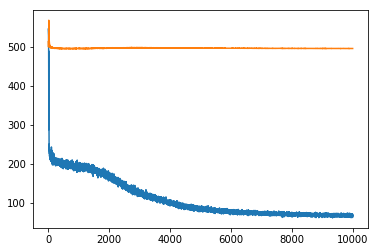

In [17]:
steps = range(train_iters)
plt.plot(steps, Lxs)
plt.plot(steps, Lzs)
plt.show()

Nesse ponto vamos verificar como o modelo gera novos dígitos. <br />
Para gerá-los, só precisamos executar o nó no gráfo que resulta na matriz canvas.

In [18]:
# model_name = 'draw_attn'
# model_path = './model/{}.ckpt'.format(model_name)

with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, model_path)
    
    X, _ = mnist.train.next_batch(batch_size)
    
    canvas = sess.run(c, {x:X})

INFO:tensorflow:Restoring parameters from ./model/draw_attn.ckpt


In [19]:
# transformando em numpy array
images = np.array(canvas)

In [20]:
# aplicando sigmoid
images = 1./(1. + np.exp(-images))

c:\users\rodrigo\documents\envs\tensorflow_1_1_0\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


# Gerando o gif
Para gerar um gif, você precisa instalar o *imagemagick* porque o matplotlib não tem suporte para fazer animação.

A velocidade entre os frames você pode controlar mudando a propriedade fps.

In [21]:
from matplotlib.animation import ArtistAnimation
import matplotlib.pyplot as plt

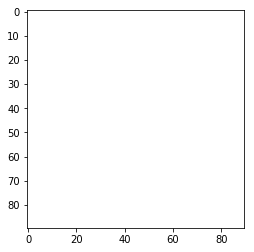

In [30]:
N = 3
padsize =  1
padval  = .5

ph = B + 2*padsize
pw = A + 2*padsize

fig, ax = plt.subplots(1, 1)

img = np.ones((N*ph, N*pw))*padval

ims = []
for t in range(T):
    samples = images[t,:N*N,:].reshape((N,N,28,28))
    for i in range(N):
        for j in range(N):
            row_s = i*ph + padsize
            row_e = row_s + B

            col_s = j*pw + padsize
            col_e = col_s + A
            img[row_s:row_e, col_s:col_e] = samples[i,j,:,:]
        im = ax.imshow(img, cmap='gray')
        ims.append([im])

ani = ArtistAnimation(fig, ims)
ani.save('animation.gif', writer='imagemagick', fps=20)